Number of species with pubmed count >= 1000: 114
Pearsonr (heu5 or heu7): 0.3944, Pearsonr (heu5): 0.3898, Pearsonr (heu7): 0.3950


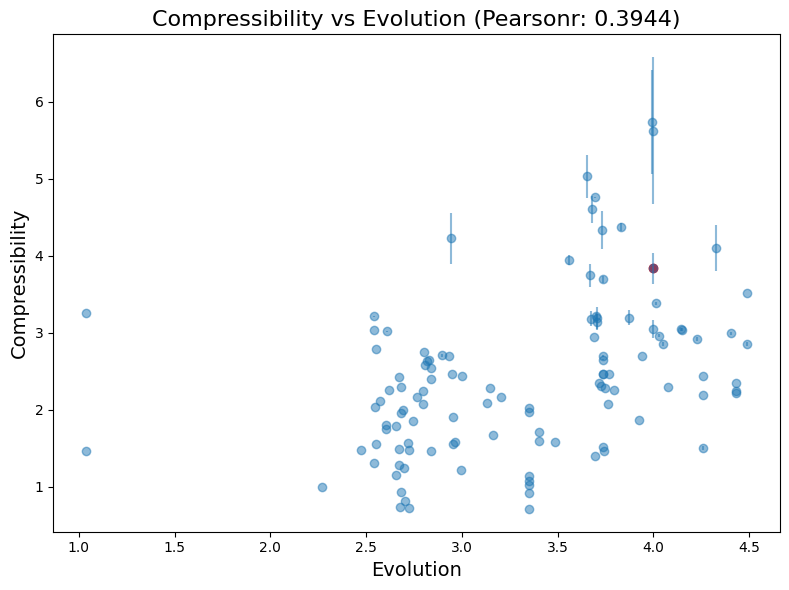

In [10]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

def get_compressibility(log_dir):
    rates_upper = np.load(os.path.join(log_dir, 'rates_upper.npy'))
    c = rates_upper[0] - rates_upper.mean()
    # c = rates_upper.max() - rates_upper.mean()
    return c

# read file and ignore the line starting with #
df_pubmed = pd.read_csv('../data/treeoflife.species.pubmed.count.tsv', sep='\t', comment='#')
df_pubmed_ge1000 = df_pubmed[df_pubmed['Publication_count'] >= 1000]
species_pubmed_ge1000 = df_pubmed_ge1000['Species_ID'].tolist()
df_evolution = pd.read_csv('../data/treeoflife.species.evolution.tsv', sep='\t')
df_evolution = df_evolution[df_evolution['Species_ID'].isin(species_pubmed_ge1000)]
print(f'Number of species with pubmed count >= 1000: {len(df_evolution)}')
species2evolution = {row['Species_ID']: row['Evolution'] for _, row in df_evolution.iterrows()}
species2compress = {}
species2compress_heu5 = {}
species2compress_heu7 = {}
species2compress_heu5_std = {}
species2compress_heu7_std = {}
species2compress_std = {}

log_dir_heu5 = '../logs/logs_interactomes.max_cc.rw1000/heu_5_no_time'
log_dir_heu7 = '../logs/logs_interactomes.max_cc.rw1000/heu_7_no_time'
for species in species2evolution:
    if os.path.exists(os.path.join(log_dir_heu5, f'rate_distortion_{species}_1')):
        compress_heu5_list = []
        compress_heu7_list = []
        compress_list = []
        for i in range(50):
            c_heu5 = get_compressibility(os.path.join(log_dir_heu5, f'rate_distortion_{species}_{i}'))
            c_heu7 = get_compressibility(os.path.join(log_dir_heu7, f'rate_distortion_{species}_{i}'))
            c = max(c_heu5, c_heu7)
            compress_heu5_list.append(c_heu5)
            compress_heu7_list.append(c_heu7)
            compress_list.append(c)
        species2compress_heu5[species] = np.mean(compress_heu5_list)
        species2compress_heu7[species] = np.mean(compress_heu7_list)
        species2compress[species] = np.mean(compress_list)
        species2compress_heu5_std[species] = np.std(compress_heu5_list)
        species2compress_heu7_std[species] = np.std(compress_heu7_list)
        species2compress_std[species] = np.std(compress_list)
    else:
        c_heu5 = get_compressibility(os.path.join(log_dir_heu5, f'rate_distortion_{species}_0'))
        c_heu7 = get_compressibility(os.path.join(log_dir_heu7, f'rate_distortion_{species}_0'))
        c = max(c_heu5, c_heu7)
        species2compress_heu5[species] = c_heu5
        species2compress_heu7[species] = c_heu7
        species2compress[species] = c
        species2compress_heu5_std[species] = 0.0
        species2compress_heu7_std[species] = 0.0
        species2compress_std[species] = 0.0

evolutions = []
compressibilities = []
compressibilities_heu5 = []
compressibilities_heu7 = []
compressibilities_std = []
compressibilities_heu5_std = []
compressibilities_heu7_std = []
homo_sapiens_idx = None
count = 0
for species in species2evolution:
    evolutions.append(species2evolution[species])
    compressibilities.append(species2compress[species])
    compressibilities_heu5.append(species2compress_heu5[species])
    compressibilities_heu7.append(species2compress_heu7[species])
    compressibilities_std.append(species2compress_std[species])
    compressibilities_heu5_std.append(species2compress_heu5_std[species])
    compressibilities_heu7_std.append(species2compress_heu7_std[species])
    if species == 9606:
        homo_sapiens_idx = count
    count += 1

pearsonr = np.corrcoef(evolutions, compressibilities)[0, 1]
pearsonr_heu5 = np.corrcoef(evolutions, compressibilities_heu5)[0, 1]
pearsonr_heu7 = np.corrcoef(evolutions, compressibilities_heu7)[0, 1]
print(f'Pearsonr (heu5 or heu7): {pearsonr:.4f}, Pearsonr (heu5): {pearsonr_heu5:.4f}, Pearsonr (heu7): {pearsonr_heu7:.4f}')

# plot compressibility vs evolution with std and highlight Homo sapiens
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.errorbar(evolutions, compressibilities_heu7, yerr=compressibilities_heu7_std, fmt='o', alpha=0.5)
ax.scatter(evolutions[homo_sapiens_idx], compressibilities_heu7[homo_sapiens_idx], color='red', label='Homo sapiens')
ax.set_xlabel('Evolution', fontsize=14)
ax.set_ylabel('Compressibility', fontsize=14)
ax.set_title(f'Compressibility vs Evolution (Pearsonr: {pearsonr:.4f})', fontsize=16)
plt.tight_layout()
plt.show()